# Install the todels package
uses for colab

In [ ]:
!git clone https://github.com/Esmokes17/todels

fatal: destination path 'todels' already exists and is not an empty directory.


In [ ]:
%cd todels

/content/todels


In [ ]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/todels
  Preparing metadata (setup.py) ... done
  Created wheel for Todels: filename=Todels-0.0.1-py3-none-any.whl size=13247 sha256=bd2ceed13749ec25abfbbcd29238dd042ec2de6ce94050114f5de9061d7256a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9yfmhyrn/wheels/d4/e1/3e/48056d2ee4f06129eac53f6704c4600ef9617b7ca10187a463
Successfully built Todels
  Attempting uninstall: Todels
    Found existing installation: Todels 0.0.1
    Uninstalling Todels-0.0.1:
      Successfully uninstalled Todels-0.0.1


# Imports

In [2]:
from random import random

from todels.utils import *
from todels.residual.resnet import Resnet18

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Pytorch version:", torch.__version__)

Device: cuda:0
Pytorch version: 1.13.1+cu116


# Parmaeters

In [4]:
EPOCHS = 100
LEARNING_RATE = 0.1
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9
IMAGES_SIZE = 32
VAL_SPLIT_SIZE = 0.1
BATCH_SIZE = 512
SCHEDULAR_GAMMA = 0.98
DATASET_PATH = "./data"

# Dataset

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Transforms

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGES_SIZE, IMAGES_SIZE)),
    transforms.RandomResizedCrop((IMAGES_SIZE,IMAGES_SIZE), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGES_SIZE, IMAGES_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

inv_normalize = lambda x : x / 2 + 0.5

## Create Data Loader

In [7]:
train_data = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=train_transforms)
test_data = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_size = int((1-VAL_SPLIT_SIZE) * len(train_data))
val_size = len(train_data) - train_size
train_split, val_split = torch.utils.data.random_split(train_data, [train_size, val_size])

In [9]:
train_loader = torch.utils.data.DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

## Show

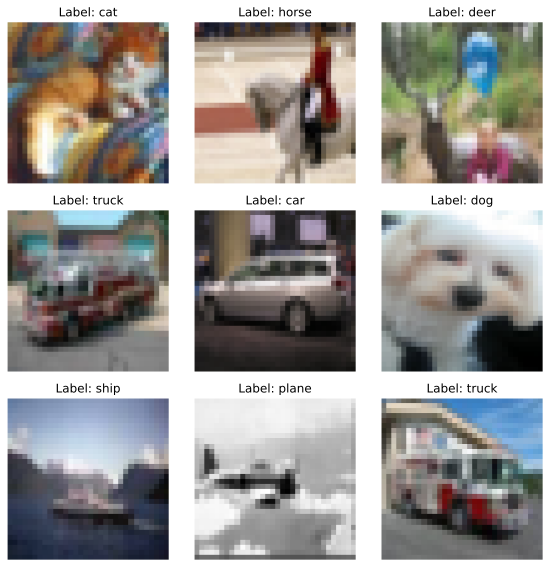

In [10]:
fig = plt.figure(figsize=(8, 8))
for i in range(9):
    rand_idx = int(random() * len(test_data))
    img = test_data[rand_idx][0]
    img = inv_normalize(img)  # unnormalize
    fig.add_subplot(3, 3, i+1)
    plt.title(f"Label: {classes[test_data[rand_idx][1]]}")
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.tight_layout()
plt.show()

# Functions

## Test Fucntion

In [13]:
@torch.no_grad()
def test(model, test_loader, loss_function=None):
    accuracy = 0
    total = 0
    running_loss = 0
    for (images, labels) in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        if loss_function is not None:
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
        _, predicts = torch.max(outputs.data, 1)
        accuracy += (predicts == labels).sum().item()
        total += labels.size(0)
    res = [(accuracy / total * 100.)]
    if loss_function is not None:
        res += [(running_loss/len(test_loader))]
    return res

## Train functions

In [14]:
def train(model, train_loader, validation_loader, optimizer, loss_function, scheduler, checkpoint, epochs):
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    best_accuracy = 0
    total_time_train = 0
    early_stopping = EarlyStopping(0.2)
    for epoch in range(epochs):
        running_loss = 0
        accuracy = 0
        total_size = 0
        for batch, (images, labels) in enumerate(train_loader):
            # move to target device (gpu)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # predict
            model.zero_grad()
            outputs = model(images)
            # cal accuracy
            _, predicts = torch.max(outputs.data, 1)
            accuracy += (predicts == labels).sum().item()
            total_size += labels.size(0)
            # cal loss
            loss = loss_function(outputs, labels)
            loss.backward()
            # optimizer step
            optimizer.step()
            # update progress bar
            running_loss += loss.item()
            print(f"\repoch {epoch+1}: loss={running_loss/(batch+1):>.4f}", end=" ")

        # append to history
        accuracies.append(accuracy / total_size * 100.)
        losses.append(running_loss / len(train_loader))

        # scheduler
        scheduler.step()

        # test validation data
        val_accuracy, val_loss = test(model, validation_loader, loss_function)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
        # early stop
        if early_stopping.check(val_loss):
            print(f"- accuracy={accuracies[-1]:>.4f}% - val_loss={val_losses[-1]:>.4f} - val_accuracy={val_accuracies[-1]:>.4f}%")
            print("-----------\n Early stop!")
            return {"loss": losses, "val_loss": val_losses, "accuracy": accuracies, "val_accuracy": val_accuracies}
        
        checkpoint(val_loss)

        # step progress_bar
        addition_output = f"loss = {losses[-1]:>.4f} - accuracy = {accuracies[-1]:>.4f}% - val_loss = {val_losses[-1]:>.4f} - val_accuracy: {val_accuracies[-1]:>.4f}%"
        print(f"- accuracy={accuracies[-1]:>.4f}% - val_loss={val_losses[-1]:>.4f} - val_accuracy={val_accuracies[-1]:>.4f}%")

    return {"loss": losses, "val_loss": val_losses, "accuracy": accuracies, "val_accuracy": val_accuracies}

## Show Predicts Samples

In [15]:
@torch.no_grad()
def show_predicts(model, test_data, n_test=5):
    fig, ax = plt.subplots(2, n_test, figsize=(12, 4))
    model.eval()
    for i in range(n_test):
        rand_index = int(random() * len(test_data))
        image = test_data[rand_index][0]
        img = inv_normalize(image)  # unnormalize
        predicts = model(image.unsqueeze(0).to(device))
        ax[0, i].set_title(f"actual = {classes[int(test_data[rand_index][1])]}")
        ax[0, i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax[0, i].axis(False)
        predicts = nn.functional.softmax(predicts, dim=-1)
        hbars = ax[1, i].barh(classes, predicts.cpu().numpy().flatten() * 100., align='center')
        ax[1, i].set_xlim([0, 100])
        fig.tight_layout()
    plt.show()

## Plot Metrics Function

In [16]:
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1)
    axes[0].set_title("Loss")
    axes[0].plot(history["loss"], label="loss")
    axes[0].plot(history["val_loss"], label="val_loss")
    axes[0].legend()

    axes[1].set_title("Accuracy")
    axes[1].plot(history["accuracy"], label="accuracy")
    axes[1].plot(history["val_accuracy"], label="val_accuracy")
    axes[1].legend()
    
    plt.tight_layout(pad=2)
    plt.xlabel("epochs")
    plt.show()

# Create Model & Train

## Init Model & Optimizer

In [19]:
resnet18 = Resnet18(10, is_light=True, device=device)
resnet18.fc = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(512, 10, device=device),
)
summary(resnet18, (3,IMAGES_SIZE,IMAGES_SIZE))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         ConvBlock-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         ConvBlock-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        ConvBlock-11           [-1, 64, 16, 16]               0
         Identity-12           [-1, 64, 16, 16]               0
   ResnetShortcut-13           [-1, 64, 16, 16]               0
             ReLU-14           [-1, 64,

In [20]:
torch.cuda.empty_cache()

torch.cuda.empty_cache()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(EPOCHS*0.75), EPOCHS], gamma=SCHEDULAR_GAMMA)
loss_fn = nn.CrossEntropyLoss().to(device)
checkpoint = Checkpoint(resnet18, "Resnet18-CIFAR10.ckpt")

## Train Model

In [21]:
history_resnet = train(resnet18, train_loader, val_loader, optimizer, loss_fn, scheduler, checkpoint, EPOCHS)
model = checkpoint.load()  # load best model 

epoch 1: loss=1.6425 - accuracy=40.7044% - val_loss=1.3858 - val_accuracy=50.5000%
epoch 2: loss=1.2492 - accuracy=54.7956% - val_loss=1.1339 - val_accuracy=59.8600%
epoch 3: loss=1.0499 - accuracy=62.6644% - val_loss=0.9724 - val_accuracy=65.0200%
epoch 4: loss=0.8822 - accuracy=69.0067% - val_loss=0.8881 - val_accuracy=68.6000%
epoch 5: loss=0.7616 - accuracy=73.3333% - val_loss=0.7975 - val_accuracy=72.5400%
epoch 6: loss=0.6805 - accuracy=76.1756% - val_loss=0.7703 - val_accuracy=73.3800%
epoch 7: loss=0.6179 - accuracy=78.3200% - val_loss=0.6764 - val_accuracy=76.3000%
epoch 8: loss=0.5566 - accuracy=80.6800% - val_loss=0.6698 - val_accuracy=76.5800%
epoch 9: loss=0.5139 - accuracy=82.0111% - val_loss=0.6520 - val_accuracy=78.3600%
epoch 10: loss=0.4705 - accuracy=83.5667% - val_loss=0.6205 - val_accuracy=79.2600%
epoch 11: loss=0.4292 - accuracy=85.0022% - val_loss=0.6137 - val_accuracy=79.2600%
epoch 12: loss=0.3996 - accuracy=86.1644% - val_loss=0.5984 - val_accuracy=79.5200%
e

## Plot Metrics

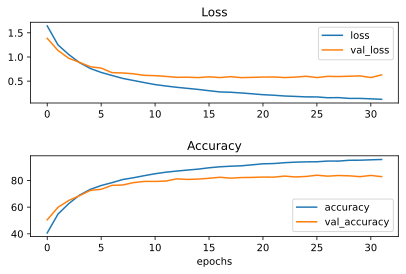

In [22]:
plot_metrics(history_resnet)

## Test

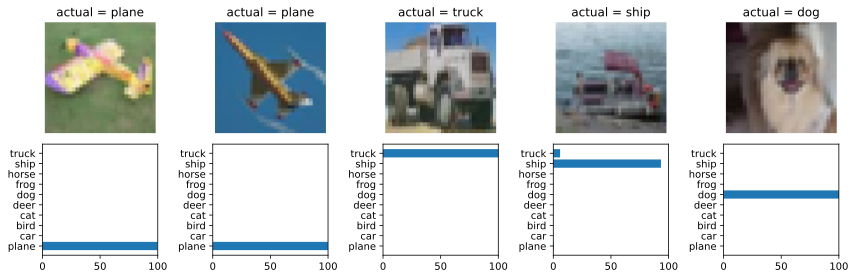

In [23]:
show_predicts(model, test_data)

In [24]:
accuracy, loss = test(model, test_loader, loss_fn)
print(f"accuracy = {accuracy:>.2f}%")
print(f"loss = {loss:>.2f}")

accuracy = 96.11%
loss = 0.13
